# VS con cristales de la *proteína CDK2*
## Análisis de resultados
Esta libreta muestra los resultados del análisis de acoplamiento molecular realizado con las 402 estructuras cristalográficas de la proteína CDK2.  
Los datos a analizar en este apartado fueron obtenidos le la siguiente manera:

- Se obtuvieron los ligandos de la base de datos de CSAR 2012.
    - Se obtuvieron un total de **111 ligandos**, de los cuales **27** mostraron alguna afinidad experimental hacia la proteína.
- Se alinearon las estructuras de las 402 proteínas usando los residuos de Pisani, 2016.
- Se determinó el tamaño de la caja de búsqueda para el docking considerando las 402 estructuras, de tal manera que la caja cubriese los sitios catalíticos de las 402 conformaciones.
- Se utilizaron los programas *AD vina*, *Vinardo (Smina)* y *AD4* para realizar los acoplamientos.
- Para cada uno de los 111 ligandos se obtuvieron 402 resultados, es decir, 402 valores de energía de acoplamiento hacia CDK2, un valor por conformación cristalográfica.
- Visto de otra manera, para cada una de las 402 conformaciones de la proteína, se obtuvo un *ranking* de los 111 ligandos, basado en el **scoring** obtenido por cada uno de los tres programas usados.

### A continuación se muestra el análisis de los resultados

In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

Cargamos la tabla de datos con la información de las 402 estructuras cirstalográficas de la proteína.

In [70]:
df_cdk2_labels = pd.read_json(r"./B_DATOS/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO_LABELS.json")
df_cdk2_labels.head(5)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass,Labels_conf
1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.00,298,92.953020,2,"[8, 13]","[[36, 43], [149, 161]]",1,['STU'],STU,440.0,inact_b
1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.00,298,97.315436,1,[8],"[[36, 43]]",3,"['ACE', 'ATP', 'MG']",ATP,398.0,inact_a
1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.10,298,97.315436,1,[8],"[[36, 43]]",3,"['ACE', 'ATP', 'MG']",ATP,398.0,inact_a
1buh,crystal structure of the human cdk2 kinase com...,1998-09-09,2,A,2.60,298,96.308725,2,"[7, 4]","[[40, 46], [295, 298]]",0,[],,,inact_a
1ckp,human cyclin dependent kinase 2 complexed with...,1999-01-13,1,A,2.05,298,93.624161,2,"[8, 11]","[[36, 43], [153, 163]]",2,"['EDO', 'PVB']",PVB,214.0,inact_a


### Datos CDK2 de CSAR
Cargamos la tabla de datos de las 111 moléculas analizadas por CSAR. Dichos datos se encuentran en el siguiente [enlace](https://drugdesigndata.org/about/datasets/220).

In [71]:
csar_data = pd.read_excel('../ARCHIVOS/CDK2_Binding_Data_Corrected_2016AUG18.xlsx', sheet_name="Binding", index_col=0)
csar_data[["PDB ID", "Experimental Result, Average Value", "ActiveInactive"]].head(10)
# Limpiamos los datos y asignamos el valor de activo
csar_data["ActiveInactive"].fillna("Active", inplace=True)
# para el caso del ligando CS12, que es activo pero no posee valor de pKi
csar_data.at["CS12", "Experimental Result, Average Value"] = 99999
# Se ordena el índice
reindex = csar_data.index.to_series().str.rsplit('S').str[-1].astype(int).sort_values()
# Se reasigna el indice
csar_data = csar_data.reindex(index= reindex.index)

In [72]:
csar_data.head(3)

,Data Source,Target,SMILES,Chemical Series,"Experimental Result, Average Value Operator","Experimental Result, Average Value","Experimental Result, SEM","Experimental Result, Type","Experimental Result, Unit","Experimental Result, Protocol","Experimental Result, comment",PDB ID,LIGAND ID,ActiveInactive
Compound_ID,,,,,,,,,,,,,,
CS1,UnivMichigan,CDK2 Kinase,Brc1ccc(cc1)C(=O)Nc1n[nH]c(c1)C CS1,1.0,NaN,33200,7040.0,Kd,nM,OctetRed_Method1,NaN,4EK4,NaN,Active
CS2,UnivMichigan,CDK2 Kinase,O=C(Nc1n[nH]c(c1)C1CC1)CCC CS2,1.0,NaN,1840,368.0,Kd,nM,OctetRed_Method1,NaN,NaN,NaN,Active
CS3,UnivMichigan,CDK2 Kinase,O=C(Nc1n[nH]c(c1)C1CC1)c1ccc(cc1)C(=O)N CS3,1.0,NaN,808,114.0,Kd,nM,OctetRed_Method1,NaN,4EK5,NaN,Active


### Comienza el análisis
#### Directorio de resultados
Los resultados de cada conformación fueron guardados en archivos *csv*.

In [5]:
import glob
dir_dockings = "../ARCHIVOS/CRISTALES/DOCKINGS/DOCK_402_PROT_111_LIGS/"

### Autodock 4
Debido a que los dockings se obtuvieron en dos tandas para el caso de algunas proteinas es necesario hacer el siguiente procesamiento de datos.

In [10]:
# Directorios con los resultados
archivos_ad4_p1 = glob.glob(dir_dockings + 'AD4/CSV/*')
# Se commprobo en la primera tanda que a 47 proteinas le faltaba al menos un ligando de los 111
# Se identificaron los ligandos faltantes; un total de 20 ligandos los cuales se evaluaron para las 47 proteinas identificadas
# Los resultados se guardaron en el siguiente directorio
archivos_ad4_p2 = glob.glob(dir_dockings + 'AD4/CSV_prot_ligs_faltantes/*')

Algunas de las 47 proteinas tenian mas ligandos faltantes que otras, por lo que se evaluaron nuevamente todas las proteinas con los hasta 20 posibles ligandos faltantes. Con ello, es posible que para alguna proteina se haya evaluado el mismo ligando hasta dos veces. Asi que el siguiente paso es cargar los datos pero omitiendo la duplicacion de los resultados.

#### Generamos una lista de las proteinas con acoplamientos pendientes

In [17]:
prot_faltantes = []
for i in archivos_ad4_p1:
    n_ligs = pd.read_csv(i).shape[0]
    if n_ligs < 111:
        prot_faltantes.append( i.split("/")[-1].split("_")[0])
# Se genera la lista con 47 elementos
len(prot_faltantes)

47

#### Generamos una fncion para leer los datos
Para cada archivo de resultados (csv) nos interesa el nombre del ligando, mostrado en la columna `lowestEnergy_dlgfn`, y los valores de ls columnas `LE` y `LE_LC`.

In [89]:
def get_docking_results_vina(col_Energy):
    dir_ad4_comp = dir_dockings + 'AD4/CSV_prot_ligs_faltantes/'

    df_final = pd.DataFrame(csar_data["ActiveInactive"]) # Creamos el dataframe que se irá llenando
    df_final.index.names = ["Ligando"] # Renombramos el índice
    df_final # Las filas con los 111 ligandos ya estan ordenadas

    # Cargamos uno a uno los resultados de las proteinas y las concatenamos
    for file in archivos_ad4_p1:
        pdb_index = file.split("/")[-1].split("_")[0] # Obtenemos el pdbid
        df = pd.read_csv(file) # Cargamos el dataframe
        df_res = df[['lowestEnergy_dlgfn', col_Energy]] # Tomamos solo las columnas de interes
        df_res.set_index("lowestEnergy_dlgfn", inplace = True) # Establecemos el indice
        # Comprobamos si hacen falta ligandos
        if len(df_res) < 111:
            # Cargamos el archivo complementario
            df_comp = pd.read_csv(glob.glob( dir_ad4_comp + pdb_index + '_results.csv')[0])
            df_comp_res = df_comp[['lowestEnergy_dlgfn', col_Energy]]
            df_comp_res.set_index("lowestEnergy_dlgfn", inplace = True)
            # Drop de las filas con los ligandos presentes en el df complementario
            intersectos = df_res.index.intersection(df_comp_res.index)
            df_res.drop(intersectos, inplace = True)
            # Concatenamos los resultados, def_res ahora es igual a def_res + def_comp
            df_res = pd.concat([df_res, df_comp_res], ignore_index=False)
            # Salimos del ciclo y continuamos
        df_res.index.names = ['Ligando'] # Renombramos el indice
        df_res.columns = [pdb_index] # Renombramos la columna
        # Se ordena el índice
        i = df_res.index.to_series().str.rsplit('S').str[-1].astype(int).sort_values()
        # Se reasigna el indice
        df_res_ord = df_res.reindex(index= i.index)
        # Se anade df_res_ord al dataframe principal
        df_final[ pdb_index ] = df_res_ord[ pdb_index ]
    return(df_final)

#### Se generan las tablas de resultados para AD4, tanto para LC y LE
Finalmente, generamos las tablas de resultados para AD4.

In [91]:
df_AD4_results_LE = get_docking_results_vina(' LE')
df_AD4_results_LC = get_docking_results_vina(' LE_LC')

## Vina y Vinardo

In [44]:
dir_vina_res = dir_dockings + 'VINA/CSV/'
dir_vina_16_res = dir_dockings + 'VINA/CSV_16/'
df_vina_results = pd.DataFrame(csar_data["ActiveInactive"]) # Creamos el dataframe que se irá llenando
df_vina_results.index.names = ["Ligando"] # Renombramos el índice

dir_vinardo_res = dir_dockings + 'VINARDO/CSV/'
dir_vinardo_16_res = dir_dockings + 'VINARDO/CSV_16/'
df_vinardo_results = pd.DataFrame(csar_data["ActiveInactive"]) # Creamos el dataframe que se irá llenando
df_vinardo_results.index.names = ["Ligando"] # Renombramos el índice

In [45]:
def get_docking_results_vina(df_final, dir_1, dir_2):
    ''' Función para procesar los resultados del docking de Vina y Vinardo'''
    for pdb_id in df_cdk2_labels.index:
        # Leemos los datasets
        """ Como tenemos dos directorios de resultados, debido a que se hizo el docking en dos partes, cargamos cada resultado. """
        file_a = glob.glob(dir_1 + pdb_id + "*")
        file_b = glob.glob(dir_2 + pdb_id + "*")

        a = pd.read_csv(file_a[0])
        b = pd.read_csv(file_b[0])
        # Concatena los resultados
        c = pd.concat([a, b], ignore_index=True)
        # Establece un indice
        c.set_index("Ligando", inplace=True)
        # Se ordena el índice
        i = c.index.to_series().str.rsplit('S').str[-1].astype(int).sort_values()
        # Se reasigna el indice
        c = c.reindex(index= i.index)
        # Se renombra la columna
        colname = c.columns[0].rsplit("_")[1]
        c.columns = [ colname ]
        # Se añade al dataframe principal
        df_final[ colname ] = c[ colname ]

Se obtienen los resultados usando la función definida arriba.

In [46]:
get_docking_results_vina(df_vina_results, dir_vina_res, dir_vina_16_res)

get_docking_results_vina(df_vinardo_results, dir_vinardo_res, dir_vinardo_16_res)

# Vina

In [8]:
activos =  df_vina_results.ActiveInactive == "Active"

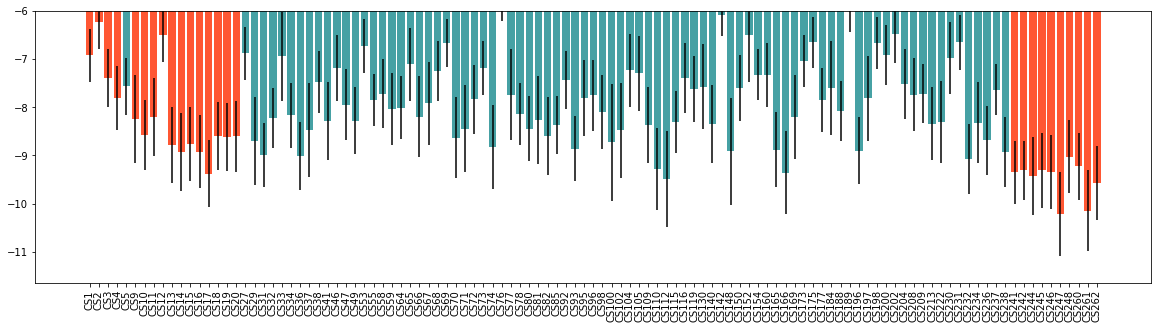

In [9]:
sc_promedio_vrd = df_vinardo_results.mean(axis=1)
error_vrd = df_vinardo_results.std(axis=1)

fig = plt.figure(figsize=(20, 5))
plt.bar( df_vinardo_results.index, sc_promedio_vrd , yerr = error_vrd, color="#46A1A4" )
plt.bar( df_vinardo_results[ activos ].index, sc_promedio_vrd[ activos ], color="#FF5733" )
plt.xticks(rotation=90); plt.ylim(top=-6); 
plt.show()


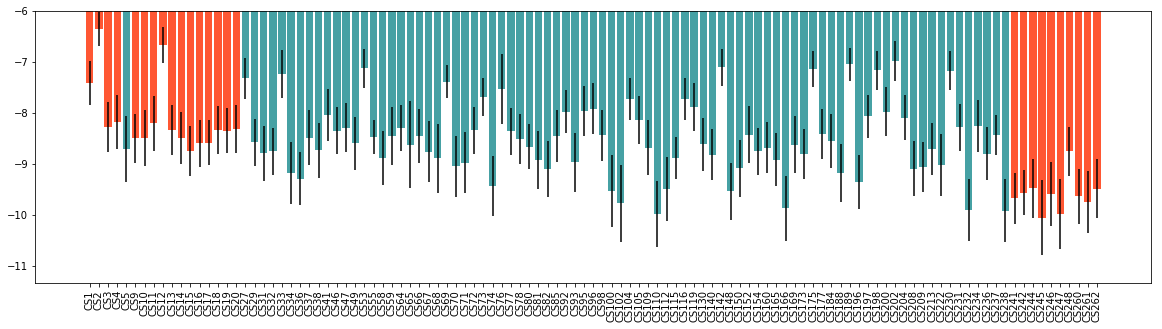

In [10]:
sc_promedio_vina = df_vina_results.mean(axis=1)
error_vina = df_vina_results.std(axis=1)

fig = plt.figure(figsize=(20, 5))
plt.bar( df_vina_results.index, sc_promedio_vina, yerr = error_vina, color="#46A1A4" )
plt.bar( df_vina_results[ activos ].index, sc_promedio_vina[ activos ], color="#FF5733" )
plt.xticks(rotation=90); plt.ylim(top=-6); 
plt.show()

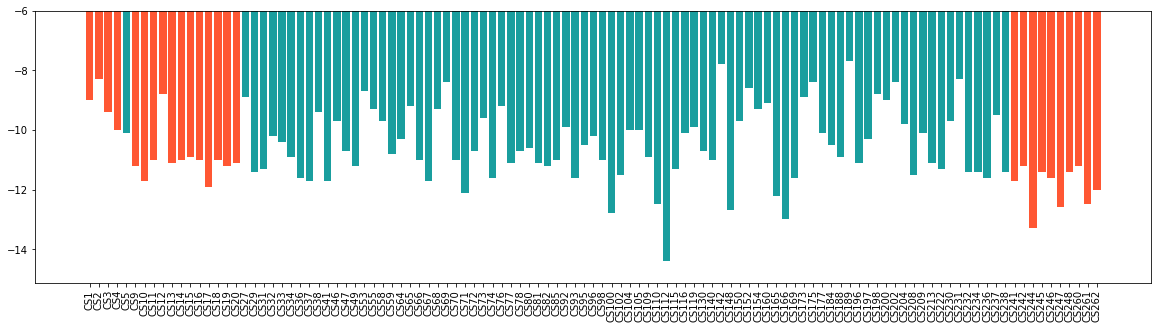

In [11]:
sc_minimo_vrd = df_vinardo_results.min(axis=1)

fig = plt.figure(figsize=(20, 5))
plt.bar( df_vinardo_results.index, sc_minimo_vrd, color="#199E9E" )
plt.bar( df_vinardo_results[ activos ].index, sc_minimo_vrd[ activos ], color="#FF5733" )
plt.xticks(rotation=90); plt.ylim(top=-6)
plt.show()

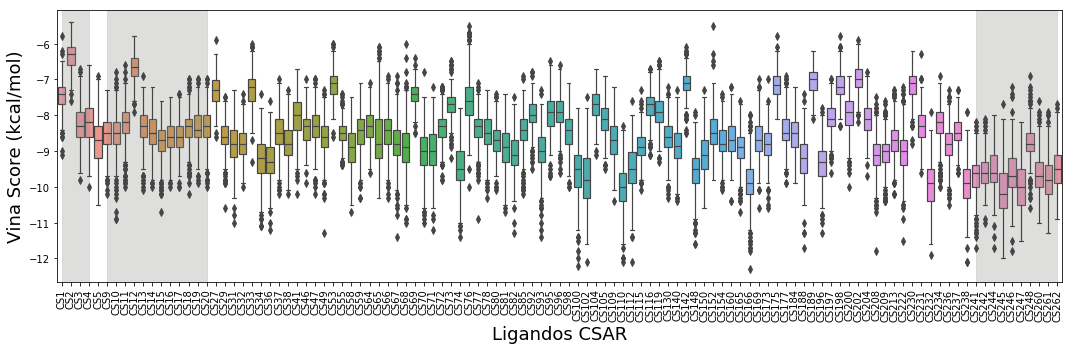

In [15]:
import seaborn as sns
num_ligs, num_conf = df_vina_results[ df_cdk2_labels.index ].shape

fig, ax = plt.subplots(figsize =(18, 5))
sns.set_style("white"); sns.set_context("paper")
ax.axvspan(0, 3, color=sns.xkcd_rgb['grey'], alpha=0.3)
ax.axvspan(5, 16, color=sns.xkcd_rgb['grey'], alpha=0.3)
ax.axvspan(101, 110, color=sns.xkcd_rgb['grey'], alpha=0.3)
sns.boxplot(ax = ax,  data = df_vina_results[ df_cdk2_labels.index ].T )
#plt.title(F"VINA: Boxplots - {num_ligs} ligandos - {num_conf} conformaciones")
plt.xticks(rotation=90)
ax.set_ylabel('Vina Score (kcal/mol)', fontsize=18)
ax.set_xlabel('Ligandos CSAR', fontsize=18)
plt.show()

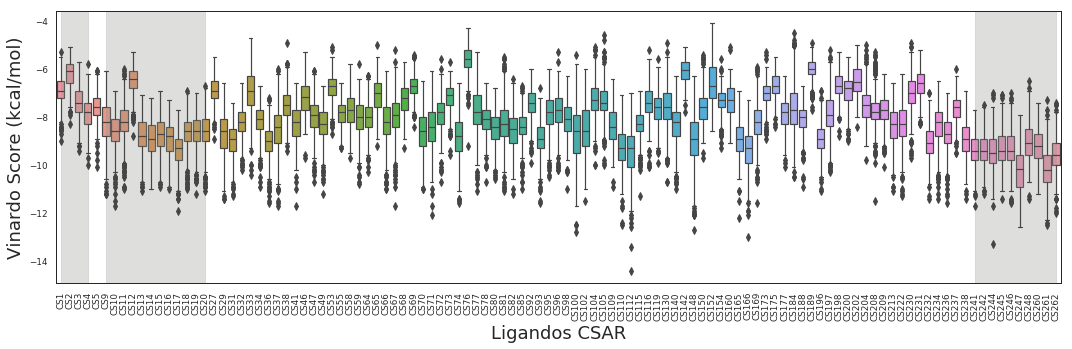

In [16]:
import seaborn as sns
num_ligs, num_conf = df_vinardo_results[ df_cdk2_labels.index ].shape

fig, ax = plt.subplots(figsize =(18, 5))
sns.set_style("white"); sns.set_context("paper")
ax.axvspan(0, 3, color=sns.xkcd_rgb['grey'], alpha=0.3)
ax.axvspan(5, 16, color=sns.xkcd_rgb['grey'], alpha=0.3)
ax.axvspan(101, 110, color=sns.xkcd_rgb['grey'], alpha=0.3)
sns.boxplot(ax = ax,  data = df_vinardo_results[ df_cdk2_labels.index ].T )
# plt.title(F"VINARDO: Boxplots - {num_ligs} ligandos - {num_conf} conformaciones")
plt.xticks(rotation=90)
ax.set_ylabel('Vinardo Score (kcal/mol)', fontsize=18)
ax.set_xlabel('Ligandos CSAR', fontsize=18)
plt.show()

## ROC - Curvas ROC


In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [29]:
# Etiquetas de los lgandos, 1 = Activo
print(true_values)

[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [35]:
# Valores del scoring de vina (promedio)
# Se multiplican por -1 para invertir las posiciones en el ranking
np.array(- sc_promedio_vina )[1:10]

array([6.35895522, 8.27810945, 8.18358209, 8.71393035, 8.50248756,
       8.49452736, 8.2079602 , 6.67537313, 8.33482587])

In [39]:
true_values = [ 1 if i == "Active" else 0 for i in csar_data["ActiveInactive"]]
# Scorings de Vina y Vinardo
sc_promedio_vrd = df_vinardo_results.mean(axis=1)
sc_promedio_vina = df_vina_results.mean(axis=1)

print('AUC del valor promedio')
print("Vina (AUC del scoring promedio):", roc_auc_score( y_true = np.array(true_values),  
                                                         y_score = np.array(- sc_promedio_vina )) )
print("Vinardo (AUC del scoring promedio):", roc_auc_score( y_true = np.array(true_values),  
                                                            y_score = np.array(- sc_promedio_vrd )) )

AUC del valor promedio
Vina (AUC del scoring promedio): 0.5524886877828055
Vinardo (AUC del scoring promedio): 0.7610859728506787


In [40]:
?roc_auc_score

In [41]:
sc_min_vrd = df_vinardo_results.min(axis=1)
sc_min_vina = df_vina_results.min(axis=1)

print('AUC del valor maximo de las 402 evaluaciones por ligando')
print("Vina (scoring minimo):", roc_auc_score(np.array(true_values),  np.array(- sc_min_vina )) )
print("Vinardo (scoring minimo):", roc_auc_score(np.array(true_values),  np.array(- sc_min_vrd )) )

AUC del valor maximo de las 402 evaluaciones por ligando
Vina (scoring minimo): 0.5366515837104072
Vinardo (scoring minimo): 0.652262443438914


#### Calculo de la curva

In [140]:
# Calculo de las tasas FP, TP y umbrales
fpr_vn, tpr_vn, thresholds_vn = roc_curve( np.array(true_values), np.array(- sc_promedio_vrd ))
print(F'Etiquetas {true_values}')
print(F'Scores ordenados {sorted( - round(sc_promedio_vrd, 3), reverse=True ) }')
print(F'FPR: {tpr_vn}')
print(F'FPR: {fpr_vn}')
print(F'Umbrales: { np.round(thresholds_vn, 3) }')

Etiquetas [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Scores ordenados [10.211, 10.142, 9.565, 9.492, 9.427, 9.38, 9.354, 9.349, 9.344, 9.308, 9.306, 9.282, 9.223, 9.071, 9.024, 9.019, 8.991, 8.93, 8.926, 8.924, 8.913, 8.898, 8.88, 8.857, 8.825, 8.776, 8.762, 8.729, 8.698, 8.689, 8.63, 8.618, 8.606, 8.6, 8.595, 8.579, 8.479, 8.473, 8.444, 8.442, 8.37, 8.367, 8.344, 8.343, 8.32, 8.306, 8.302, 8.287, 8.278, 8.26, 8.245, 8.216, 8.21, 8.205, 8.195, 8.164, 8.146, 8.099, 8.076, 8.039, 8.008, 7.945, 7.921, 7.851, 7.85, 7.838, 7.819, 7.817, 7.811, 7.752, 7.744, 7.736, 7.716, 7.716, 7.638, 7.63, 7.605, 7.604, 7.572, 7.569, 7.516, 7.472, 7.433, 7.398, 7.395, 7.337, 7.322, 7.297, 7.247, 7.236, 7.184, 7.184, 7.11

### Demostraciones de la curva ROC
#### **Curva ROC ideal**  
Para ello vamos a crear un arreglo de *scorings* donde los verdaderos positivos queden con los valores de menor energia, es decir, que en el ranking final queden chasta arriba en la posicion del ranking.

In [47]:
# Creamos el ranking ideal
sc_ideal = [ -10 if i == 1 else 0 for i in true_values]
print(sc_ideal)

[-10, -10, -10, -10, 0, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10]


In [52]:
auc_ideal = roc_auc_score( y_true = np.array(true_values),  
                           y_score =  - np.array(sc_ideal ))
print(F"Vina (AUC del scoring IDEAL): {auc_ideal}")

Vina (AUC del scoring IDEAL): 1.0


In [73]:
# Calculo de las tasas FP, TP y umbrales
fpr_id, tpr_id, thresholds_id = roc_curve( np.array(true_values), - np.array(sc_ideal ))
print(F'Scores ordenados {sorted( - np.round(sc_ideal, 3), reverse=True ) }')
print(F'FPR: {tpr_id}')
print(F'FPR: {fpr_id}')
print(F'Umbrales: { np.round(thresholds_id, 3) }')

Scores ordenados [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
FPR: [0. 1. 1.]
FPR: [0. 0. 1.]
Umbrales: [11 10  0]


<Figure size 432x288 with 0 Axes>

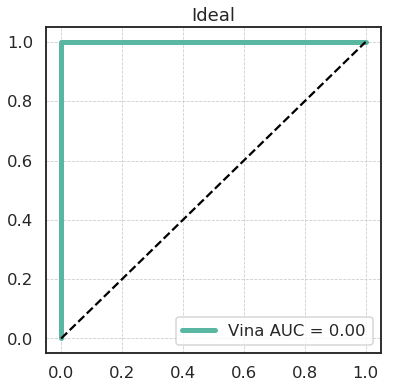

In [81]:
plt.figure()
fig = plt.figure(figsize=(6, 6))
sns.set_style("white"); sns.set_context("talk")
plt.plot(fpr_id, tpr_id, color="#59B7A1", label='Vina AUC = %0.2f' % auc_ideal, lw = 5)
plt.legend()
plt.plot([0, 1], [0, 1], 'k--')
plt.grid(linestyle='--', linewidth='0.8')
plt.title('Ideal')
plt.show();

#### **Curva ROC NO ideal**

In [82]:
auc_NO_ideal = roc_auc_score( y_true = np.array(true_values),  
                           y_score =  np.array(sc_ideal )) # Omitimos multiplicar por -1
print(F"Vina (AUC del scoring NO ideal): {auc_NO_ideal}")

Vina (AUC del scoring NO ideal): 0.0


In [78]:
# Calculo de las tasas FP, TP y umbrales
fpr_Nid, tpr_Nid, thresholds_Nid = roc_curve( np.array(true_values),  np.array(sc_ideal ))
print(F'Scores ordenados {sorted( np.round(sc_ideal, 3), reverse=True ) }')
print(F'FPR: {tpr_Nid}')
print(F'FPR: {fpr_Nid}')
print(F'Umbrales: { np.round(thresholds_Nid, 3) }')

Scores ordenados [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10]
FPR: [0. 0. 1.]
FPR: [0. 1. 1.]
Umbrales: [  1   0 -10]


<Figure size 432x288 with 0 Axes>

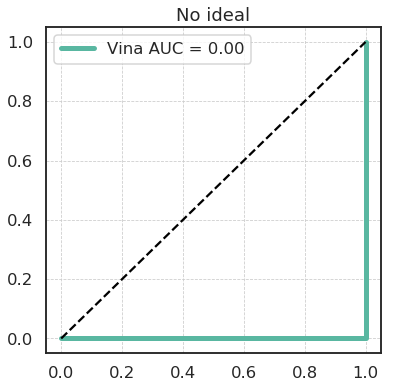

In [80]:
plt.figure()
fig = plt.figure(figsize=(6, 6))
sns.set_style("white"); sns.set_context("talk")
plt.plot(fpr_Nid, tpr_Nid, color="#59B7A1", label='Vina AUC = %0.2f' % auc_ideal, lw = 5)
plt.legend()
plt.plot([0, 1], [0, 1], 'k--')
plt.grid(linestyle='--', linewidth='0.8')
plt.title("No ideal")
plt.show();

#### **Curva ROC Aleatoria**

In [107]:
# Creamos el ranking aleatorio
sc_random = np.random.normal(loc = -5.0, scale = 2.0, size = 111)
#sc_random

In [108]:
auc_random = roc_auc_score( y_true = np.array(true_values),  
                           y_score = - sc_random) # Multplicamos por -1 
print(F"Vina (AUC del scoring NO ideal): {auc_random}")

Vina (AUC del scoring NO ideal): 0.4923076923076923


In [112]:
# Calculo de las tasas FP, TP y umbrales
fpr_rdm, tpr_rdm, thresholds_rdm = roc_curve( np.array(true_values),  np.array(sc_random))
print(F'Scores ordenados {sorted( np.round(sc_random, 3), reverse=True ) }')
print(F'FPR: {tpr_rdm}')
print(F'FPR: {fpr_rdm}')
print(F'Umbrales: { np.round(thresholds_rdm, 3) }')

Scores ordenados [-0.787, -1.595, -1.669, -1.805, -1.926, -1.976, -2.152, -2.376, -2.511, -2.526, -2.739, -2.761, -2.762, -2.843, -3.013, -3.075, -3.099, -3.113, -3.19, -3.259, -3.307, -3.343, -3.388, -3.477, -3.519, -3.704, -3.795, -3.801, -3.801, -3.895, -3.993, -3.998, -4.005, -4.017, -4.054, -4.077, -4.152, -4.183, -4.213, -4.316, -4.405, -4.515, -4.519, -4.551, -4.576, -4.582, -4.67, -4.827, -4.853, -4.857, -4.86, -4.907, -4.914, -4.937, -5.017, -5.13, -5.146, -5.206, -5.215, -5.242, -5.294, -5.332, -5.381, -5.391, -5.397, -5.415, -5.476, -5.502, -5.737, -5.797, -5.862, -5.914, -5.932, -6.054, -6.117, -6.139, -6.167, -6.167, -6.2, -6.26, -6.326, -6.403, -6.425, -6.435, -6.538, -6.622, -6.635, -6.733, -6.768, -6.774, -6.972, -7.017, -7.429, -7.479, -7.513, -7.672, -7.737, -7.807, -7.846, -7.895, -7.906, -7.955, -8.34, -8.662, -8.663, -8.715, -8.865, -9.439, -9.66, -10.107, -10.553]
FPR: [0.         0.03846154 0.03846154 0.07692308 0.07692308 0.11538462
 0.11538462 0.15384615 0.1538

<Figure size 432x288 with 0 Axes>

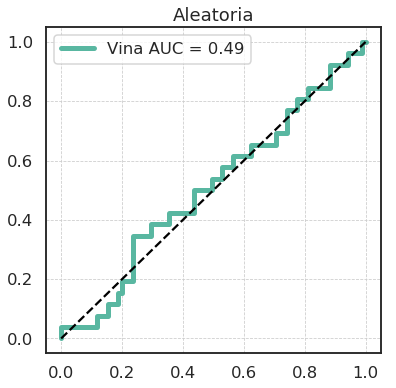

<Figure size 432x288 with 0 Axes>

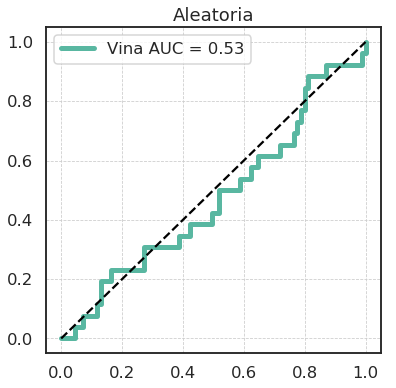

In [145]:
# Creamos el ranking aleatorio
sc_random = np.random.normal(loc = -5.0, scale = 2.0, size = 111)
auc_random = roc_auc_score( y_true = np.array(true_values),  
                           y_score = - sc_random) # Multplicamos por -1 
# Calculo de las tasas FP, TP y umbrales
fpr_rdm, tpr_rdm, thresholds_rdm = roc_curve( np.array(true_values),  np.array(sc_random))

plt.figure()
fig = plt.figure(figsize=(6, 6))
sns.set_style("white"); sns.set_context("talk")
plt.plot(fpr_rdm, tpr_rdm, color="#59B7A1", label='Vina AUC = %0.2f' % auc_random, lw = 5)
plt.legend()
plt.plot([0, 1], [0, 1], 'k--')
plt.grid(linestyle='--', linewidth='0.8')
plt.title("Aleatoria")
plt.show();

#### AUC de todas las conformaciones

In [326]:
# Calcular la curva roc de cada conformacion
# Vina
df_cdk2_labels["ROC_vrd"] = 0.0
df_cdk2_labels["ROC_vina"] = 0.0
for pdb in df_cdk2_labels.index:
    roc_vrd = roc_auc_score(np.array(true_values), - df_vinardo_results[ pdb ])
    df_cdk2_labels.at[ pdb, "ROC_vrd"] = roc_vrd
    roc_vina = roc_auc_score(np.array(true_values), - df_vina_results[ pdb ])
    df_cdk2_labels.at[ pdb, "ROC_vina"] = roc_vina

##### Curva ROC de una conformación a modo de ejemplo

In [563]:
max_auc_pdb_id_vina = df_cdk2_labels.ROC_vina.idxmax()
max_auc_pdb_id_vrd = df_cdk2_labels.ROC_vrd.idxmax()

'2vv9'

3unj


<Figure size 432x288 with 0 Axes>

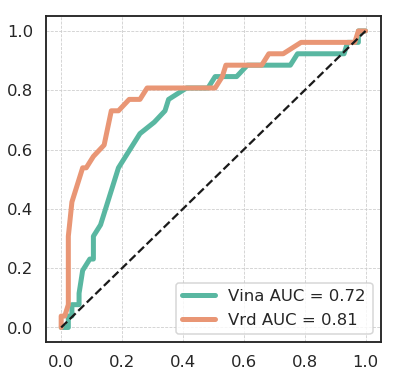

In [624]:
pdb_id = max_auc_pdb_id_vina
print(max_auc_pdb_id_vina)

fpr_vn, tpr_vn, thresholds_vn = roc_curve( np.array(true_values), - df_vina_results[ pdb_id ])#max_auc_pdb_id_vina ])
fpr_vd, tpr_vd, thresholds_vd = roc_curve( np.array(true_values), - df_vinardo_results[ pdb_id ])# max_auc_pdb_id_vrd ])

auc_vin = roc_auc_score(np.array(true_values), - df_vina_results[ pdb_id ])
auc_vrd = roc_auc_score(np.array(true_values), - df_vinardo_results[ pdb_id ])

plt.figure()
fig = plt.figure(figsize=(6, 6))
sns.set_style("white"); sns.set_context("talk")
plt.plot(fpr_vn, tpr_vn, color="#59B7A1", label='Vina AUC = %0.2f' % auc_vin, lw = 5)
plt.plot(fpr_vd, tpr_vd, color="#E99675", label='Vrd AUC = %0.2f' % auc_vrd, lw = 5)
plt.legend()
plt.plot([0, 1], [0, 1], 'k--')
plt.grid(linestyle='--', linewidth='0.8')
plt.show()

### Mejor conformación de vianrdo

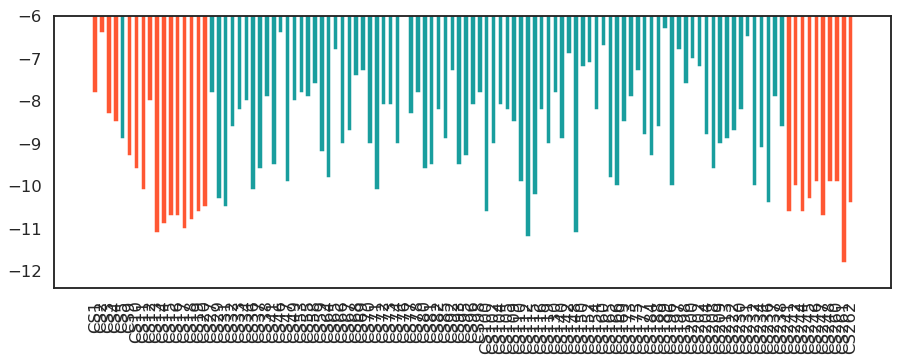

In [618]:
sc_minimo_vrd = df_vinardo_results.min(axis=1)

fig = plt.figure(figsize=(15, 5))
plt.bar( df_vinardo_results.index, df_vinardo_results["3unj"], color="#199E9E" )
plt.bar( df_vinardo_results[ activos ].index, df_vinardo_results["3unj"][ activos ], color="#FF5733" )
plt.xticks(rotation=90); plt.ylim(top=-6)
plt.show()

In [623]:
df_cdk2_labels.loc["2vv9"]

Title          cdk2 in complex with an imidazole piperazine
Date                                    2008-08-05 00:00:00
Entities                                                  1
ChainID                                                   A
Resolution                                              1.9
Identity                                                298
Coverage                                            93.6242
NumGaps                                                   2
GapLen                                              [6, 13]
GapPos                               [[38, 43], [150, 162]]
NumLigs                                                   2
NameLigs                                     ['ACE', 'IM9']
Inhib                                                   IM9
Inhib_mass                                            406.0
Labels_conf                                         inact_b
ROC_vrd                                            0.848643
ROC_vina                                

## Mejores 20 conformaciones para cada método

In [605]:
# Top 20 de vinardo
df_cdk2_labels.nlargest(20, "ROC_vrd").index

Index(['2vv9', '2r3p', '6guf', '2iw8', '4eor', '1urw', '1vyz', '4fkj', '1h07',
       '4cfn', '4bzd', '2btr', '3unk', '3lfn', '2r64', '2c4g', '5nev', '1oiq',
       '3sqq', '3ig7'],
      dtype='object')

In [606]:
# Top 20 de vina
df_cdk2_labels.nlargest(20, "ROC_vina").index

Index(['3unj', '2r3o', '1oiq', '3tiz', '3rpy', '3ddp', '3unk', '2xnb', '4bzd',
       '3s0o', '3sw4', '2r64', '2c6m', '2r3k', '1pf8', '2r3m', '5fp6', '3eid',
       '3qu0', '3r9h'],
      dtype='object')

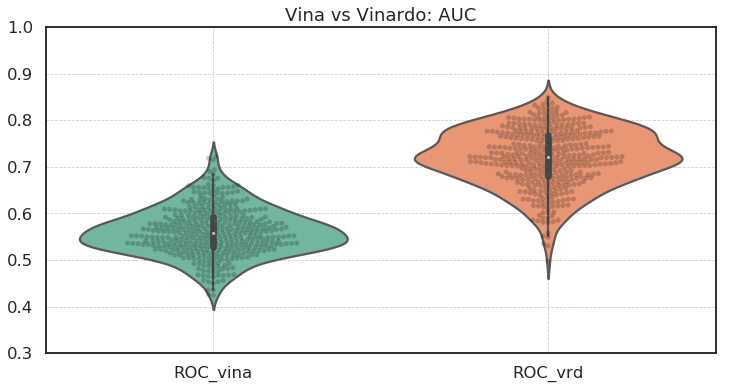

In [544]:
fig, axes = plt.subplots()
sns.set(font_scale=1.3)
sns.set_style("white"); sns.set_context("talk")
fig.set_size_inches(12, 6)
sns.violinplot(data= df_cdk2_labels[["ROC_vina", "ROC_vrd"]], ax = axes, palette="Set2", bw=.3, split=True,
    scale="width")
sns.swarmplot(data= df_cdk2_labels[["ROC_vina", "ROC_vrd"]], ax = axes, color="black", alpha=0.2)
axes.set_title('Vina vs Vinardo: AUC')
axes.grid(linestyle='--', linewidth='0.8')
plt.ylim(0.3, 1)
plt.show()

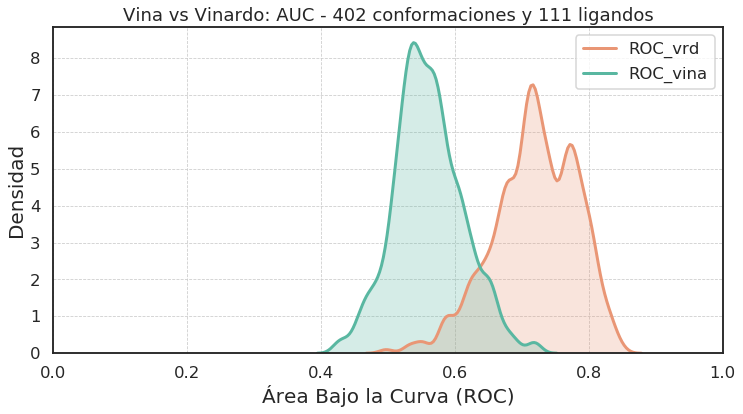

In [546]:
fig, axes = plt.subplots()
fig.set_size_inches(12, 6)
sns.set(font_scale=1.3)
sns.set_style("white"); sns.set_context("talk")
sns.kdeplot(data= df_cdk2_labels["ROC_vrd"], shade=True, ax = axes, color="#E99675", bw=.01, linewidth=3)
sns.kdeplot(data= df_cdk2_labels["ROC_vina"], shade=True, ax = axes, color="#59B7A1", bw=.01, linewidth=3)
axes.set_title('Vina vs Vinardo: AUC - 402 conformaciones y 111 ligandos')
axes.set_xlabel('Área Bajo la Curva (ROC)', fontsize=20)
axes.set_ylabel('Densidad', fontsize=20)
axes.grid(linestyle='--', linewidth='0.8')
plt.xlim(0, 1)
plt.show()

#### Pruebas de Normalidad

In [487]:
from scipy import stats
sw_vina = stats.shapiro(df_cdk2_labels["ROC_vina"])
sw_vinardo = stats.shapiro(df_cdk2_labels["ROC_vrd"])
print(sw_vinardo)
print(sw_vina)

(0.9818457961082458, 6.150403351057321e-05)
(0.992731511592865, 0.04830658435821533)


In [473]:
# Homogeneidad de varianzas
bartlett_vin_vrd = stats.levene(df_cdk2_labels["ROC_vina"], df_cdk2_labels["ROC_vrd"])
bartlett_vin_vrd

LeveneResult(statistic=12.534537121214615, pvalue=0.0004225252758200242)

In [475]:
stats.ttest_ind(df_cdk2_labels["ROC_vina"], df_cdk2_labels["ROC_vrd"], equal_var = False)

Ttest_indResult(statistic=-39.43558077510088, pvalue=1.4637454871645885e-187)

In [489]:
stats.ttest_rel(df_cdk2_labels["ROC_vina"], df_cdk2_labels["ROC_vrd"])

Ttest_relResult(statistic=-56.63441381841986, pvalue=2.0560138536875582e-193)

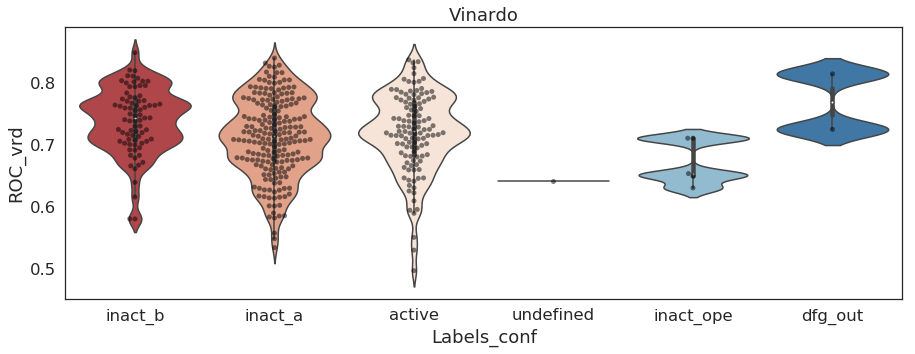

In [479]:
fig, axes = plt.subplots()
fig.set_size_inches(15, 5)
sns.violinplot(x="Labels_conf", y="ROC_vrd", 
               data= df_cdk2_labels, ax = axes, palette="RdBu", bw=.2,  scale="width")
sns.swarmplot(x="Labels_conf", y="ROC_vrd", 
               data= df_cdk2_labels, ax = axes, color="black", alpha=0.5)
axes.set_title('Vinardo')
plt.show()

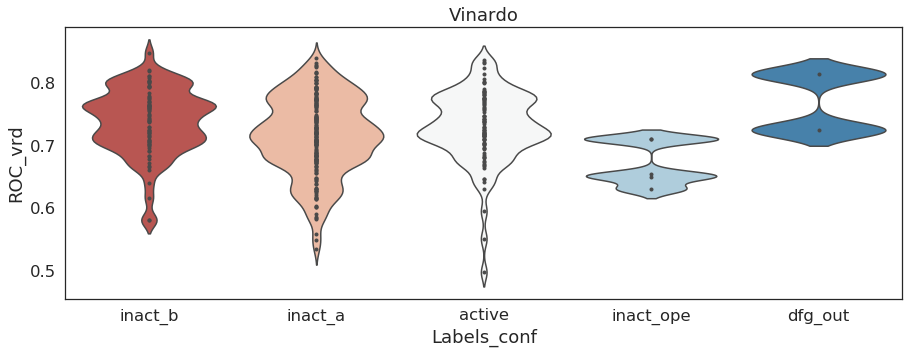

In [478]:
fig, axes = plt.subplots()
fig.set_size_inches(15, 5)
sns.violinplot(x="Labels_conf", y="ROC_vrd", 
               data= df_cdk2_labels[df_cdk2_labels.Inhib != ""], 
               ax = axes, palette="RdBu", bw=.2,  scale="width", inner="points")
axes.set_title('Vinardo')
plt.show()

In [432]:
df_cdk2_labels[df_cdk2_labels.Labels_conf == "active"]

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass,Labels_conf,ROC_vrd,ROC_vina
1e9h,thr 160 phosphorylated cdk2 - human cyclin a3 ...,2001-10-11,2,A,2.50,295,99.328859,1,[2],"[[296, 297]]",2,"['INR', 'TPO']",INR,332.0,active,0.742534,0.577376
1f5q,crystal structure of murine gamma herpesvirus ...,2000-12-27,2,A,2.50,298,99.328859,1,[2],"[[10, 11]]",1,['CL'],,,active,0.595928,0.435294
1fin,cyclin a-cyclin-dependent kinase 2 complex,1997-01-27,2,A,2.30,298,100.000000,0,[],[],1,['ATP'],ATP,398.0,active,0.747511,0.532805
1fq1,crystal structure of kinase associated phospha...,2001-05-09,2,B,3.00,297,99.328859,1,[2],"[[296, 297]]",3,"['ATP', 'MG', 'TPO']",ATP,398.0,active,0.497285,0.466516
1fvv,the structure of cdk2/cyclin a in complex with...,2001-01-17,2,A,2.80,298,100.000000,0,[],[],1,['107'],107,434.0,active,0.738914,0.595928
1gy3,"pcdk2/cyclin a in complex with mgadp, nitrate ...",2002-04-29,3,A,2.70,297,99.328859,1,[2],"[[296, 297]]",5,"['ATP', 'GOL', 'MG', 'NO3', 'TPO']",ATP,350.0,active,0.550905,0.426018
1h1p,structure of human thr160-phospho cdk2/cyclin ...,2002-09-19,2,A,2.10,297,99.664430,1,[2],"[[297, 298]]",2,"['CMG', 'TPO']",CMG,230.0,active,0.709502,0.561765
1h1q,structure of human thr160-phospho cdk2/cyclin ...,2002-09-19,2,A,2.50,297,99.664430,1,[2],"[[297, 298]]",2,"['2A6', 'TPO']",2A6,302.0,active,0.594570,0.488235
1h1r,structure of human thr160-phospho cdk2/cyclin ...,2002-09-19,2,A,2.00,297,99.664430,1,[2],"[[297, 298]]",2,"['6CP', 'TPO']",6CP,302.0,active,0.688688,0.549774
1h1s,structure of human thr160-phospho cdk2/cyclin ...,2002-09-19,2,A,2.00,297,99.664430,1,[2],"[[297, 298]]",2,"['4SP', 'TPO']",4SP,380.0,active,0.753846,0.534842


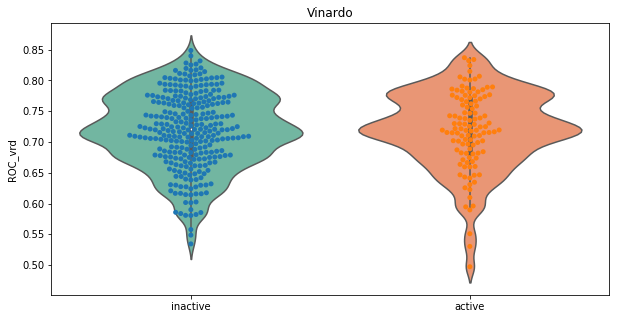

In [427]:
fig, axes = plt.subplots()
fig.set_size_inches(10, 5)
active_inactive_labels = [ "active" if i == "active" else "inactive" for i in df_cdk2_labels.Labels_conf]
sns.violinplot(x=active_inactive_labels, y=df_cdk2_labels["ROC_vrd"], ax = axes, palette="Set2", bw=.2, scale="width")
sns.swarmplot(x=active_inactive_labels, y=df_cdk2_labels["ROC_vrd"], ax = axes)
axes.set_title('Vinardo')
plt.show()

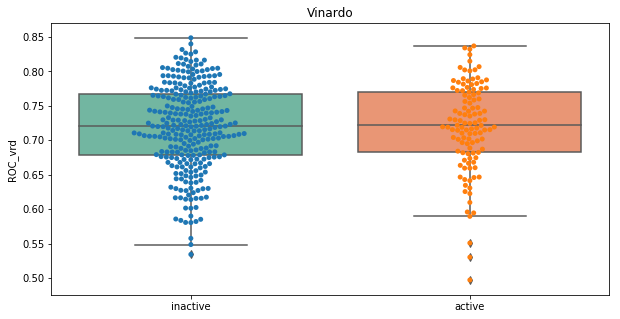

In [431]:
fig, axes = plt.subplots()
fig.set_size_inches(10, 5)
active_inactive_labels = [ "active" if i == "active" else "inactive" for i in df_cdk2_labels.Labels_conf]
sns.boxplot(x=active_inactive_labels, y=df_cdk2_labels["ROC_vrd"], ax = axes, palette="Set2")
sns.swarmplot(x=active_inactive_labels, y=df_cdk2_labels["ROC_vrd"], ax = axes)
axes.set_title('Vinardo')
plt.show()

In [430]:
len(df_cdk2_labels[df_cdk2_labels.Labels_conf == "active"])

114

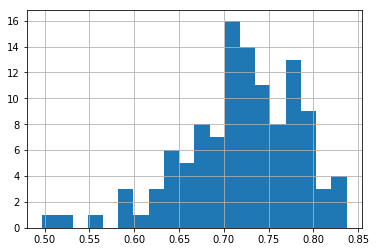

In [351]:
# Roc de las activas
( df_cdk2_labels.ROC_vrd[ df_cdk2_labels.Labels_conf == "active" ] ).hist( bins = 20)

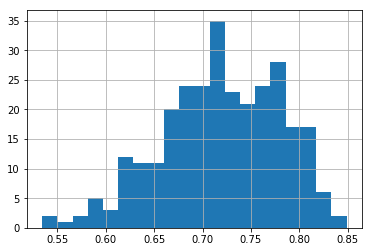

In [356]:
# Roc de las activas
( df_cdk2_labels.ROC_vrd[ df_cdk2_labels.Labels_conf != "active" ] ).hist( bins=20 )

In [433]:
from deepchem.molnet import load_pdbbind


ModuleNotFoundError: No module named 'deepchem'